In [1]:
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import numpy as np
solvers.options['show_progress'] = False

## Dynamics
In this paper, they proposed a Quadratic Program with inequality constraints:
$$
\min_{\dddot X_k} \frac{1}{2}\dddot X_k^2\\
s.t. Z_k^{min} \le Z_k \le Z_k^{max}\\
$$
where
$$
\dddot X_k = \begin{bmatrix} \dddot x_k \\ \dddot x_{k+1} \\ \vdots \\  \dddot x_{k+N-1}\end{bmatrix}; Z_k = \begin{bmatrix} z_k \\ z_{k+1} \\ \vdots \\ z_{k+N-1}\end{bmatrix}
$$
To solve this problem, we know that $Z_{k+1}=P_{zs} \hat x_k + P_{zu} \dddot X_k$, therefore, the problem could be written in the following form,
$$
\min_{\dddot X_k} \frac{1}{2}\dddot X_k^2\\
s.t. \begin{bmatrix} P_{zu} \\ -P_{zu} \end{bmatrix} \dddot X_k \le \begin{bmatrix} (Z_{max} - P_{zs}\hat x_k) \\ (P_{zs}\hat x_k - Z_{min}) \end{bmatrix} \\
$$
where
$$
P_{zs} = \begin{bmatrix} 1 & T & T^2/2-h/g \\ \vdots & \vdots & \vdots \\ 1 & NT & N^2T^2/2-h/g\end{bmatrix}\\
P_{zu} = \begin{bmatrix} T^3/6-Th/g & 0 & 0 \\ \vdots & \ddots & \vdots \\ (1+3N+3N^2)T^3/6-Th/g & \ldots & T^3/6-Th/g\end{bmatrix}\\
$$
Now the problem is in the following form and could be solved by CVXOPT qp function,
$$
\min_{u_k} \frac{1}{2}u_k^T P u_k\\
s.t. Gx \le h
$$
We find the next state using the following system dynamics,
$$
\hat x_{k+1} = A x_k + B \dddot x_k\\
z_k = \begin{bmatrix} 1 & 0 & -h/g\end{bmatrix} x_k
$$
where
$$
A = \begin{bmatrix} 1 & T & T^2/2 \\ 0 & 1 & T \\ 0 & 0 & 1\end{bmatrix};
B = \begin{bmatrix} T^3/6 \\ T^2/2 \\ T\end{bmatrix}\\
$$

In [2]:
g = 9.8   # m.s^{-2}
h = 0.8   # m
T = 0.005 # s
N = 300
t_h = 9     # s
A = np.array([[1,T,T**2/2],[0,1,T],[0,0,1]])
B = np.array([[T**3/6],[T**2/2], [T]])
C = np.array([1,0,-1*h/g])
x_0 = np.zeros((3,1))

In [3]:
def generate_min_max(t_h, T, N):
    z_min = []
    z_max = []
    t = []
    for i in range(int(t_h//T) + N):
        t.append(i*T)
        if i < (2//T):
            z_max.append([0.175])
        elif i < (3//T):
            z_max.append([-0.05])
        elif i < (4//T):
            z_max.append([0.175])
        elif i < (5//T):
            z_max.append([-0.05])
        elif i < (6//T):
            z_max.append([0.175])
        elif i < (7//T):
            z_max.append([-0.05])
        else:
            z_max.append([0.175])
            
        if i < (3//T):
            z_min.append([-0.175])
        elif i < (4//T):
            z_min.append([0.05])
        elif i < (5//T):
            z_min.append([-0.175])
        elif i < (6//T):
            z_min.append([0.05])
        elif i < (7//T):
            z_min.append([-0.175])
        else:
            z_min.append([0.05])
    return z_min, z_max, t

In [4]:
z_min, z_max, t = generate_min_max(t_h, T, N)

In [5]:
def compute_control(T, N, g, h_com, z_min, z_max, x_k):
    
    P_zs = np.zeros((N,3))
    P_zu = np.zeros((N,N))
    for i in range(N):
        P_zs[i,:] = np.array([1, (i+1)*T, ((((i+1)*T)**2)/2)-(h_com/g)])
        for j in range(i+1):
            P_zu[i,i-j] = (1+3*j+3*j**2)*(T**3)/6-T*h_com/g
    I_N = np.eye(N)
    
    P = (1/2)*I_N
    G = np.vstack((-1*P_zu,P_zu))
    h = np.vstack((P_zs@x_k-z_min,z_max-P_zs@x_k))
    
    
    P = matrix(P)
    q = matrix(np.zeros((N,1)))
    G = matrix(G)
    h = matrix(h)
    
    sol = solvers.qp(P,q,G,h)
    return np.array(sol['x'])

def system(A, B, C, x_k, u_k):
    x_k_1 = A@x_k + B@u_k
    z_k = C@x_k
    return x_k_1, z_k
    

In [6]:
x_k = x_0
Z = []
x_com = [x_0[0]]


for i in range(0,int(t_h//T)):
    U = compute_control(T, N, g, h, np.array(z_min[i:i+N]), np.array(z_max[i:i+N]),x_k)
    x_k, z_k = system(A, B, C, x_k, U[0:1])
    Z.append(z_k)
    x_com.append(x_k[0])

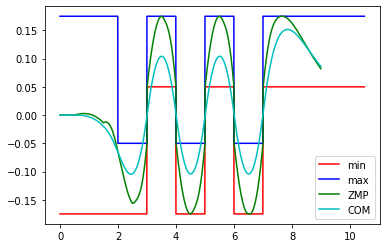

In [7]:
plt.figure(0)
plt.plot(t, z_min, '-r', label='min')
plt.plot(t, z_max, '-b', label='max')
plt.plot(t[:-N], Z, 'g', label = 'ZMP')
plt.plot(t[:-N+1], x_com, 'c', label='COM')
plt.legend()
plt.show()